# Making Recommendations Based on Correlation

## Using the "Restaurants" dataset

In [1]:
import numpy as np
import pandas as pd

In [2]:
food = pd.read_csv('../data/food.csv', index_col='student')
food.drop(['age','favorite_color'], axis=1, inplace=True)
food.head()

,broccoli,brussels_sprouts,hamburger,oysters (raw),onion (raw),peas,olives,blue_cheese,whisky
student,,,,,,,,,
Markus,8,8,0,0,10,7,9,9,5
Peter,6,6,8,7,3,7,8,9,7
Shikha,5,0,0,0,10,10,5,0,0
Hashim,8,2,9,5,2,9,8,6,0
Lina,7,6,6,0,7,7,10,6,3


Correlations between foods:

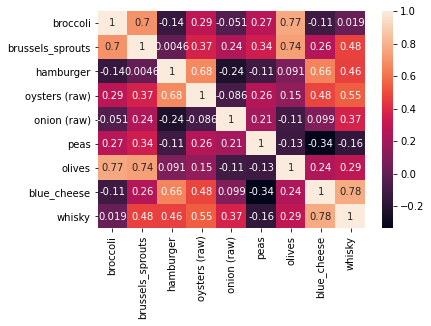

In [3]:
import seaborn as sn
import matplotlib.pyplot as plt
corrMatrix = food.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [4]:
correlations = food.corrwith(food['broccoli'])
correlations.sort_values(ascending=False)

broccoli            1.000000
olives              0.765372
brussels_sprouts    0.700526
oysters (raw)       0.288841
peas                0.269249
whisky              0.018961
 onion (raw)       -0.050823
blue_cheese        -0.114997
hamburger          -0.138389
dtype: float64

Create a function that takes as an input an ingredient and outputs the top 3 most similar ingredients based on correlation:

In [5]:
def similar_foods(ingredient, n=3):
    correlations = food.corrwith(food[ingredient])
    sorted_correlations = correlations.sort_values(ascending=False)
    return list(sorted_correlations[1:n+1].index)

In [6]:
similar_foods("broccoli")

['olives', 'brussels_sprouts', 'oysters (raw)']

## Restaurants data

These datasets are hosted on: https://archive.ics.uci.edu/ml/datasets/Restaurant+%26+consumer+data

They were originally published by: Blanca Vargas-Govea, Juan Gabriel González-Serna, Rafael Ponce-Medellín. Effects of relevant contextual features in the performance of a restaurant recommender system. In RecSys11: Workshop on Context Aware Recommender Systems (CARS-2011), Chicago, IL, USA, October 23, 2011.

In [7]:
path = '../data/restaurants/'
frame =  pd.read_csv(path + 'restaurants-rating.csv')
cuisine = pd.read_csv(path + 'chefmozcuisine.csv')
geodata = pd.read_csv(path + 'geoplaces2.csv', encoding = 'CP1252') # change encoding to 'mbcs' in Windows

On the "frame" dataset we have the ratings users have given to places. Ratings go from 0 to 2.

In [8]:
frame.head()

,userID,placeID,rating,food_rating,service_rating
0,U1077,135085,2,2,2
1,U1077,135038,2,2,1
2,U1077,132825,2,2,2
3,U1077,135060,1,2,2
4,U1068,135104,1,1,2


In the `geodata` dataset we have info about the places. We will only use the "name".

In [9]:
geodata.head()

,placeID,latitude,longitude,the_geom_meter,name,address,city,state,country,fax,...,alcohol,smoking_area,dress_code,accessibility,price,url,Rambience,franchise,area,other_services
0,134999,18.915421,-99.184871,0101000020957F000088568DE356715AC138C0A525FC46...,Kiku Cuernavaca,Revolucion,Cuernavaca,Morelos,Mexico,?,...,No_Alcohol_Served,none,informal,no_accessibility,medium,kikucuernavaca.com.mx,familiar,f,closed,none
1,132825,22.147392,-100.983092,0101000020957F00001AD016568C4858C1243261274BA5...,puesto de tacos,esquina santos degollado y leon guzman,s.l.p.,s.l.p.,mexico,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,f,open,none
2,135106,22.149709,-100.976093,0101000020957F0000649D6F21634858C119AE9BF528A3...,El Rincón de San Francisco,Universidad 169,San Luis Potosi,San Luis Potosi,Mexico,?,...,Wine-Beer,only at bar,informal,partially,medium,?,familiar,f,open,none
3,132667,23.752697,-99.163359,0101000020957F00005D67BCDDED8157C1222A2DC8D84D...,little pizza Emilio Portes Gil,calle emilio portes gil,victoria,tamaulipas,?,?,...,No_Alcohol_Served,none,informal,completely,low,?,familiar,t,closed,none
4,132613,23.752903,-99.165076,0101000020957F00008EBA2D06DC8157C194E03B7B504E...,carnitas_mata,lic. Emilio portes gil,victoria,Tamaulipas,Mexico,?,...,No_Alcohol_Served,permitted,informal,completely,medium,?,familiar,t,closed,none


In [10]:
places =  geodata[['placeID', 'name']]
places.head()

,placeID,name
0,134999,Kiku Cuernavaca
1,132825,puesto de tacos
2,135106,El Rincón de San Francisco
3,132667,little pizza Emilio Portes Gil
4,132613,carnitas_mata


In the `cuisine` dataset we have the type of cuisine that restaurants offer.

In [11]:
cuisine.head()

,placeID,Rcuisine
0,135110,Spanish
1,135109,Italian
2,135107,Latin_American
3,135106,Mexican
4,135105,Fast_Food


## Grouping and Ranking Data

Let's group places by rating, and look at their average rating. This is an **explicit** rating given by users.

In [12]:
rating = pd.DataFrame(frame.groupby('placeID')['rating'].mean())
rating.head()

,rating
placeID,
132560,0.50
132561,0.75
132564,1.25
132572,1.00
132583,1.00


We can also look at how many times each restaurant has received a rating. This is an **implicit** rating.

In [13]:
rating['rating_count'] = pd.DataFrame(frame.groupby('placeID')['rating'].count())
rating.head()

,rating,rating_count
placeID,,
132560,0.50,4
132561,0.75,4
132564,1.25,4
132572,1.00,15
132583,1.00,4


On average, places get a rating of 1,17/2, and have been rated 8,9 times:

In [14]:
rating.describe()

,rating,rating_count
count,130.000000,130.000000
mean,1.179622,8.930769
std,0.349354,6.124279
min,0.250000,3.000000
25%,1.000000,5.000000
50%,1.181818,7.000000
75%,1.400000,11.000000
max,2.000000,36.000000


Let's locate the most popular place, and get some info about it:

In [15]:
rating.sort_values('rating_count', ascending=False).head()

,rating,rating_count
placeID,,
135085,1.333333,36
132825,1.281250,32
135032,1.178571,28
135052,1.280000,25
132834,1.000000,25


In [16]:
# placeId of most popular place
top_popular_placeID = rating.sort_values('rating_count', ascending=False).head(1).index[0]

# name of the most popular place
places[places['placeID']==top_popular_placeID]

,placeID,name
121,135085,Tortas Locas Hipocampo


In [17]:
# cuisine of the most popular place
cuisine[cuisine['placeID']==top_popular_placeID]

,placeID,Rcuisine
44,135085,Fast_Food


The post popular place is "Tortas Locas Hipocampo", and it is a Fast food place.

## Preparing Data For Analysis

Next, we will look for restaurants that are similar to "Tortas Locas Hipocampo". "Similarity" will be defined by how well other places correlate with "Tortas Locas" in the user-item matrix. In this matrix, we have all the users in the rows and all the restaurants in the columns. It has many NaNs because most of the time, users have not visited many restaurants —we call this a sparse matrix.

In [18]:
places_crosstab = pd.pivot_table(data=frame, values='rating', index='userID', columns='placeID')
places_crosstab.head(10)

placeID,132560,132561,132564,132572,132583,132584,132594,132608,132609,132613,...,135080,135081,135082,135085,135086,135088,135104,135106,135108,135109
userID,,,,,,,,,,,,,,,,,,,,,
U1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
U1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN
U1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
U1005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1006,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U1007,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.0,NaN,NaN,NaN,1.0,NaN
U1008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
U1009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Let's look at the users that have visited "Tortas Locas":

In [19]:
Tortas_ratings = places_crosstab[top_popular_placeID]
Tortas_ratings[Tortas_ratings>=0] # exclude NaNs

userID
U1001    0.0
U1002    1.0
U1007    1.0
U1013    1.0
U1016    2.0
U1027    1.0
U1029    1.0
U1032    1.0
U1033    2.0
U1036    2.0
U1045    2.0
U1046    1.0
U1049    0.0
U1056    2.0
U1059    2.0
U1062    0.0
U1077    2.0
U1081    1.0
U1084    2.0
U1086    2.0
U1089    1.0
U1090    2.0
U1092    0.0
U1098    1.0
U1104    2.0
U1106    2.0
U1108    1.0
U1109    2.0
U1113    1.0
U1116    2.0
U1120    0.0
U1122    2.0
U1132    2.0
U1134    2.0
U1135    0.0
U1137    2.0
Name: 135085, dtype: float64

## Evaluating Similarity Based on Correlation

Now we will look at how well other restaurants correlate with Tortas Locas. A strong positive correlation between two restaurants indicates that users who liked one restaruant also liked the other. A negative correlation would mean that users who liked one restaurant did not like the other. So, we will look for strong, positive correlations to find similar restaurants.

In [20]:
# we get warnings because computing the pearson correlation coefficient with NaNs, but the results are still ok
similar_to_Tortas = places_crosstab.corrwith(Tortas_ratings)
similar_to_Tortas

/Users/joanclaverol/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/joanclaverol/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


placeID
132560         NaN
132561         NaN
132564         NaN
132572   -0.428571
132583         NaN
            ...   
135088         NaN
135104         NaN
135106    0.454545
135108         NaN
135109         NaN
Length: 130, dtype: float64

Many restuarants get a NaN, because there are no users that went to both that restaurant _and_ Tortas Locas. But some of them give us a correlation score. Let's drop NaNs and look at the valid results:

In [21]:
corr_Tortas = pd.DataFrame(similar_to_Tortas, columns=['PearsonR'])
corr_Tortas.dropna(inplace=True)
corr_Tortas.head(12)

,PearsonR
placeID,
132572,-0.428571
132723,0.301511
132754,0.930261
132825,0.700745
132834,0.814823
132856,0.475191
132861,0.500000
132862,0.559017
132872,0.840168


Some correlations are a perfect 1. It is possible that this is because very few users went to both that restaurant and "Tortas Locas" (also because there are very few rating options, only 0, 1 and 2). 

In [22]:
Tortas_corr_summary = corr_Tortas.join(rating['rating_count'])
Tortas_corr_summary.drop(top_popular_placeID, inplace=True) # drop Tortas Locas itself
Tortas_corr_summary

,PearsonR,rating_count
placeID,,
132572,-0.428571,15
132723,0.301511,12
132754,0.930261,13
132825,0.700745,32
132834,0.814823,25
132856,0.475191,14
132861,0.500000,7
132862,0.559017,18
132872,0.840168,12


Let's filter out restaurants with a rating count below 10.

Then, take the top 10 restaurants in terms of similarity to Tortas:

In [23]:
top10 = Tortas_corr_summary[Tortas_corr_summary['rating_count']>=10].sort_values('PearsonR', ascending=False).head(10)
top10

,PearsonR,rating_count
placeID,,
135076,1.000000,13
135066,1.000000,12
132754,0.930261,13
135045,0.912871,13
135062,0.898933,21
135028,0.892218,15
135042,0.881409,20
135046,0.867722,11
132872,0.840168,12


In [24]:
top10 = top10.merge(places, left_index=True, right_on="placeID")
top10

,PearsonR,rating_count,placeID,name
13,1.000000,13,135076,Restaurante Pueblo Bonito
52,1.000000,12,135066,Restaurante Guerra
117,0.930261,13,132754,Cabana Huasteca
28,0.912871,13,135045,Restaurante la Gran Via
113,0.898933,21,135062,Restaurante El Cielo Potosino
120,0.892218,15,135028,La Virreina
25,0.881409,20,135042,Restaurant Oriental Express
42,0.867722,11,135046,Restaurante El Reyecito
90,0.840168,12,132872,Pizzeria Julios
60,0.831513,24,135038,Restaurant la Chalita


Let's look at the cuisine type (some restaurants do not have a cuisine type... but for the ones that do, here it is):

In [25]:
top10.merge(cuisine)

,PearsonR,rating_count,placeID,name,Rcuisine
0,0.930261,13,132754,Cabana Huasteca,Mexican
1,0.892218,15,135028,La Virreina,Mexican
2,0.881409,20,135042,Restaurant Oriental Express,Chinese
3,0.867722,11,135046,Restaurante El Reyecito,Fast_Food
4,0.840168,12,132872,Pizzeria Julios,American


## Challenge:

Create a function that takes as input a restaurant id and a number (n), and outputs the names of the top n most similar restuarants to the inputed one.

You can assume that the user-item matrix (places_crosstab) is already created.

In [26]:
Tortas_ratings

userID
U1001    0.0
U1002    1.0
U1003    NaN
U1004    NaN
U1005    NaN
        ... 
U1134    2.0
U1135    0.0
U1136    NaN
U1137    2.0
U1138    NaN
Name: 135085, Length: 138, dtype: float64

In [27]:
places_crosstab.corrwith(Tortas_ratings)

/Users/joanclaverol/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/joanclaverol/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


placeID
132560         NaN
132561         NaN
132564         NaN
132572   -0.428571
132583         NaN
            ...   
135088         NaN
135104         NaN
135106    0.454545
135108         NaN
135109         NaN
Length: 130, dtype: float64

In [28]:
def top_n_rest(rest_id, n):
    """
    Let me know what is this function about
    Args**: 
        rest_id which type of variable. It should be numeric!!!
        n it is not descriptive enough. Number of closer values?
    Returns: tell me which output I will get from this function. 
        List of top n closer restaurants.
    """
#     if rest_id is not numeric: print('please should be numeric')
    rest_ratings = places_crosstab[rest_id]
    similar_to_rest = places_crosstab.corrwith(rest_ratings)
    corr_rest = pd.DataFrame(similar_to_Tortas, columns=['PearsonR'])
    corr_rest.dropna(inplace=True)
    rest_corr_summary = corr_rest.join(rating['rating_count'])
    rest_corr_summary.drop(rest_id, inplace=True) # drop the inputed restaurant itself
    top10 = rest_corr_summary[rest_corr_summary['rating_count']>=10].sort_values(
        'PearsonR', ascending=False
    ).head(n)
    
    top10 = top10.merge(places, left_index=True, right_on="placeID")
    return list(top10["name"])


In [29]:
places.query('placeID == 135072')

,placeID,name
126,135072,Sushi Itto


In [30]:
top_n_rest(135072, 5)

/Users/joanclaverol/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2634: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/joanclaverol/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2493: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


['Restaurante Pueblo Bonito',
 'Tortas Locas Hipocampo',
 'Restaurante Guerra',
 'Cabana Huasteca',
 'Restaurante la Gran Via']

In [64]:
import warnings
warnings.filterwarnings('ignore')

rating_markus =  (
places
    .merge(frame, left_on='placeID', right_on='placeID')
    .groupby('placeID')
    .agg(
        name=pd.NamedAgg(column="name", aggfunc="first"),
        count=pd.NamedAgg(column="rating", aggfunc="count"),
        avg_rating=pd.NamedAgg(column="rating", aggfunc="mean")
    )
)

def top_n_rest_markus(place_id, number=5):
    """
    function that takes as input a restaurant id and a number (n), 
    and outputs the names of the top n most similar restuarants to the inputed one
    """    
    # calculate the correlations between all restaurants.
    # drop missing values 
    # drop the restaurant id 
    similar =  pd.DataFrame(
        places_crosstab
        .corrwith(places_crosstab[place_id])
        .dropna()
        .drop(place_id)
    )
    similar.columns= ['PearsonR']
    similar = similar.sort_values(ascending=False, by='PearsonR')
    similar = similar.merge(rating_markus, left_index=True, right_index=True)
    similar = similar[similar['count'] > 10] # other options like 'query()'
    similar = list(similar["name"].values) # ['name']
    return similar[:number]
top_n_rest_markus(135072, 10)

['Cabana Huasteca',
 'Gorditas Doa Gloria',
 'Mariscos El Pescador',
 'Koye Sushi',
 'Restaurante Tiberius',
 'Gordas de morales',
 'crudalia',
 'la Cantina',
 'Tortas Locas Hipocampo',
 'Cafe Chaires']

In [88]:
# lina and khader answer
def top_n_rest_linader( restaurant_id , n ):
        
    # 1-  users that have visited restaurant_id
    restaurant_ratings = places_crosstab[restaurant_id]
    restaurant_ratings = restaurant_ratings[restaurant_ratings>=0] # exclude NaNs

    # 2- look at how well other restaurants correlate with restaurant_id
    similar_to_rest = places_crosstab.corrwith(restaurant_ratings)

    corr_rest = pd.DataFrame(similar_to_rest, columns=['PearsonR'])
    corr_rest.dropna(inplace=True)


    rest_corr_summary = corr_rest.join(rating['rating_count'])
    rest_corr_summary.drop(restaurant_id, inplace=True) # drop Tortas Locas itself

    top_n = rest_corr_summary[rest_corr_summary['rating_count']>10].sort_values('PearsonR', ascending=False).head(n)
    top_n = top_n.merge(places, left_index=True, right_on="placeID")

    res = top_n['name'].to_list()

    return res

In [89]:
top_n_rest_linader(135072, 10) == top_n_rest_markus(135072, 10)

True

In [83]:
def top_n_rest_vitaly(restaurant_id, n, min_num_reviews):
    # Input: restaurant id, n how many similar restuarants, 
    # min number of reviews to include in Tortas_corr_summary
    # places_crosstab, places,rating are already created
    # Output: names of the top n most similar restuarants
    Tortas_ratings = places_crosstab[restaurant_id]
    Tortas_ratings = Tortas_ratings[Tortas_ratings>=0] # exclude NaNs
    similar_to_Tortas = places_crosstab.corrwith(Tortas_ratings)
    corr_Tortas = pd.DataFrame(similar_to_Tortas, columns=['PearsonR'])
    corr_Tortas.dropna(inplace=True)
    Tortas_corr_summary = corr_Tortas.join(rating['rating_count'])
    Tortas_corr_summary.drop(restaurant_id, inplace=True)
    top_n = Tortas_corr_summary[Tortas_corr_summary['rating_count']>=min_num_reviews].sort_values('PearsonR', ascending=False).head(n)
    top_n = top_n.merge(places, left_index=True, right_on="placeID")
    names_of_the_top_n = list(top_n['name'])
    return names_of_the_top_n

In [86]:
top_n_rest_vitaly(135072, 11, 11) == top_n_rest_markus(135072, 10)

True

In [85]:
len(top_n_rest_markus(135072, 10))

10

In [67]:
top_n_rest(135072, 5)

['Restaurante Pueblo Bonito',
 'Tortas Locas Hipocampo',
 'Restaurante Guerra',
 'Cabana Huasteca',
 'Restaurante la Gran Via']

In [33]:
places

,placeID,name
0,134999,Kiku Cuernavaca
1,132825,puesto de tacos
2,135106,El Rincón de San Francisco
3,132667,little pizza Emilio Portes Gil
4,132613,carnitas_mata
...,...,...
125,132866,Chaires
126,135072,Sushi Itto
127,135109,Paniroles
128,135019,Restaurant Bar Coty y Pablo


In [29]:
import warnings
warnings.filterwarnings('ignore')

In [30]:
rating.sort_values(by="rating_count", ascending=False).head(12)

,rating,rating_count
placeID,,
135085,1.333333,36
132825,1.281250,32
135032,1.178571,28
135052,1.280000,25
132834,1.000000,25
135038,1.208333,24
135060,1.136364,22
135062,1.238095,21
135042,1.250000,20


In [31]:
top_n_rest(132921, 10)

['Restaurante Pueblo Bonito',
 'Tortas Locas Hipocampo',
 'Restaurante Guerra',
 'Cabana Huasteca',
 'Restaurante la Gran Via',
 'Restaurante El Cielo Potosino',
 'La Virreina',
 'Restaurant Oriental Express',
 'Restaurante El Reyecito',
 'Pizzeria Julios']

### BONUS (Next iteration)

Instead of flitering out restaurants with a rating count below 10, let's consider a restaurant X as similar to Y only if at least 3 users have gone to both X and Y.